# Momentum signals

In this example, we will examine extracting and drawing momentum signals.

We will

* Download pair and exchange map ("the trading universe")

* Create a momentum function

* Draw a momentum signal on OHLCV chart


## About momentum signals

In financial technical analysis, momentum (MTM) and rate of change (ROC) are simple indicators showing the difference between today's closing price and the close N days ago. Momentum is the absolute difference in stock, commodity:

[Read more in Wikipedia](https://en.wikipedia.org/wiki/Momentum_(technical_analysis).

## Getting started

First let's import libraries and initialise our dataset client.

In [7]:
import pandas as pd

try:
    import capitalgram
except ImportError:
    !pip install -e git+https://github.com/miohtama/capitalgram-onchain-dex-quant-data.git#egg=capitalgram
    import site
    site.main()

from capitalgram.client import Capitalgram

client = Capitalgram.create_jupyter_client()

Started Capitalgram in Jupyter notebook environment, configuration is stored in /Users/mikkoohtamaa/.capitalgram


## Importing data

We will operate on 4 hour candles across all blockchains and exchanges.
We will limit the active dataset by doing a prefiltering and cull out
trading pairs that have never been too active.
This will greatly decrease computation times, because the dataset will be much smaller.
Note that prefiltering pairs like this  will introduce survivorship bias.

In [8]:
from pyarrow import Table
from capitalgram.exchange import ExchangeUniverse
from capitalgram.pair import PandasPairUniverse
from capitalgram.timebucket import TimeBucket
from capitalgram.candle import GroupedCandleUniverse

# Exchange map data is so small it does not need any decompression
exchange_universe: ExchangeUniverse = client.fetch_exchange_universe()

# We make this notebook derministic by having start and end date for all data
start = pd.Timestamp("2020-10-01")
end = pd.Timestamp("2021-08-01")

# Fetch all trading pairs across all exchanges
# We limit the test set to pairs with minimun 50 buys and 50 sells over the lifetime
pair_table: Table = client.fetch_pair_universe()
pairs = pair_table.to_pandas()
pairs = pairs.loc[
        (pairs['buy_count_all_time'] >= 50) &
        (pairs['sell_count_all_time'] >= 50)
    ]
pair_universe = PandasPairUniverse(pairs)
pair_ids = pair_universe.get_all_pair_ids()

# Fetch all candles and filter out candles that are
# belong to the pair universe
candle_table: Table = client.fetch_all_candles(TimeBucket.h4)
candles = candle_table.to_pandas()
candles = candles.loc[
    candles["pair_id"].isin(pair_ids) &
    (candles["timestamp"] >= start) &
    (candles["timestamp"] < end)
]
candle_universe = GroupedCandleUniverse(candles)

## Momentum function

We use the momentum function from [Teddy Kroker's post](https://teddykoker.com/2019/05/momentum-strategy-from-stocks-on-the-move-in-python/).

The original code uses [BUS/252, or 252 business days per year rule](https://quant.stackexchange.com/questions/32914/bus-252-accrual-why-252). Because we are trading crypto and we are trading
4 hour candles, to annualise the momentum we use a different multiplier for the slope.

In [9]:
import numpy as np

from scipy.stats import linregress

TRADING_DAYS_IN_YEAR = 365

CANDLE_HOURS = 4

ANNUALISE_MULTIPLIER = TRADING_DAYS_IN_YEAR * (CANDLE_HOURS/24)


def calculate_momentum(closes):
    returns = np.log(closes)
    x = np.arange(len(returns))
    slope, _, rvalue, _, _ = linregress(x, returns)
    # annualize slope and multiply by R^2
    return ((1 + slope) ** ANNUALISE_MULTIPLIER) * (rvalue ** 2)

## Single pair momentum

Let's pick a pair and calculate a momentum signal for it.

We will use AAVE-ETH pair on SushiSwap.

In [10]:
from capitalgram.chain import ChainId
from capitalgram.pair import DEXPair

# Filter down to pairs that only trade on Sushiswap
sushi_swap = exchange_universe.get_by_name_and_chain(ChainId.ethereum, "sushiswap")

aave_eth: DEXPair = pair_universe.get_one_pair_from_pandas_universe(
    sushi_swap.exchange_id,
    "AAVE",
    "WETH")

print(f"AAVE-WETH pair id is {aave_eth.pair_id}")

AAVE-WETH pair id is 13137


Let's calculate momentum signal for this pair

In [11]:
aave_eth_candles = candle_universe.get_candles_by_pair(aave_eth.pair_id)

aave_eth_candles["momentum"] = aave_eth_candles["close"].rolling(90).apply(calculate_momentum, raw=False)

Let's see what kind of values we got by doing a table output, plot for close price, plot for momentum.

First let's set up matplotlib output in Jupyter Notebook to high DPI (retina)

In [19]:
import matplotlib
import matplotlib.pyplot as pyplot

matplotlib.rcParams['figure.dpi'] = 600
pyplot.style.use('dark_background')

Then let's plot the price and calculated momentum.

No handles with labels found to put in legend.
No handles with labels found to put in legend.


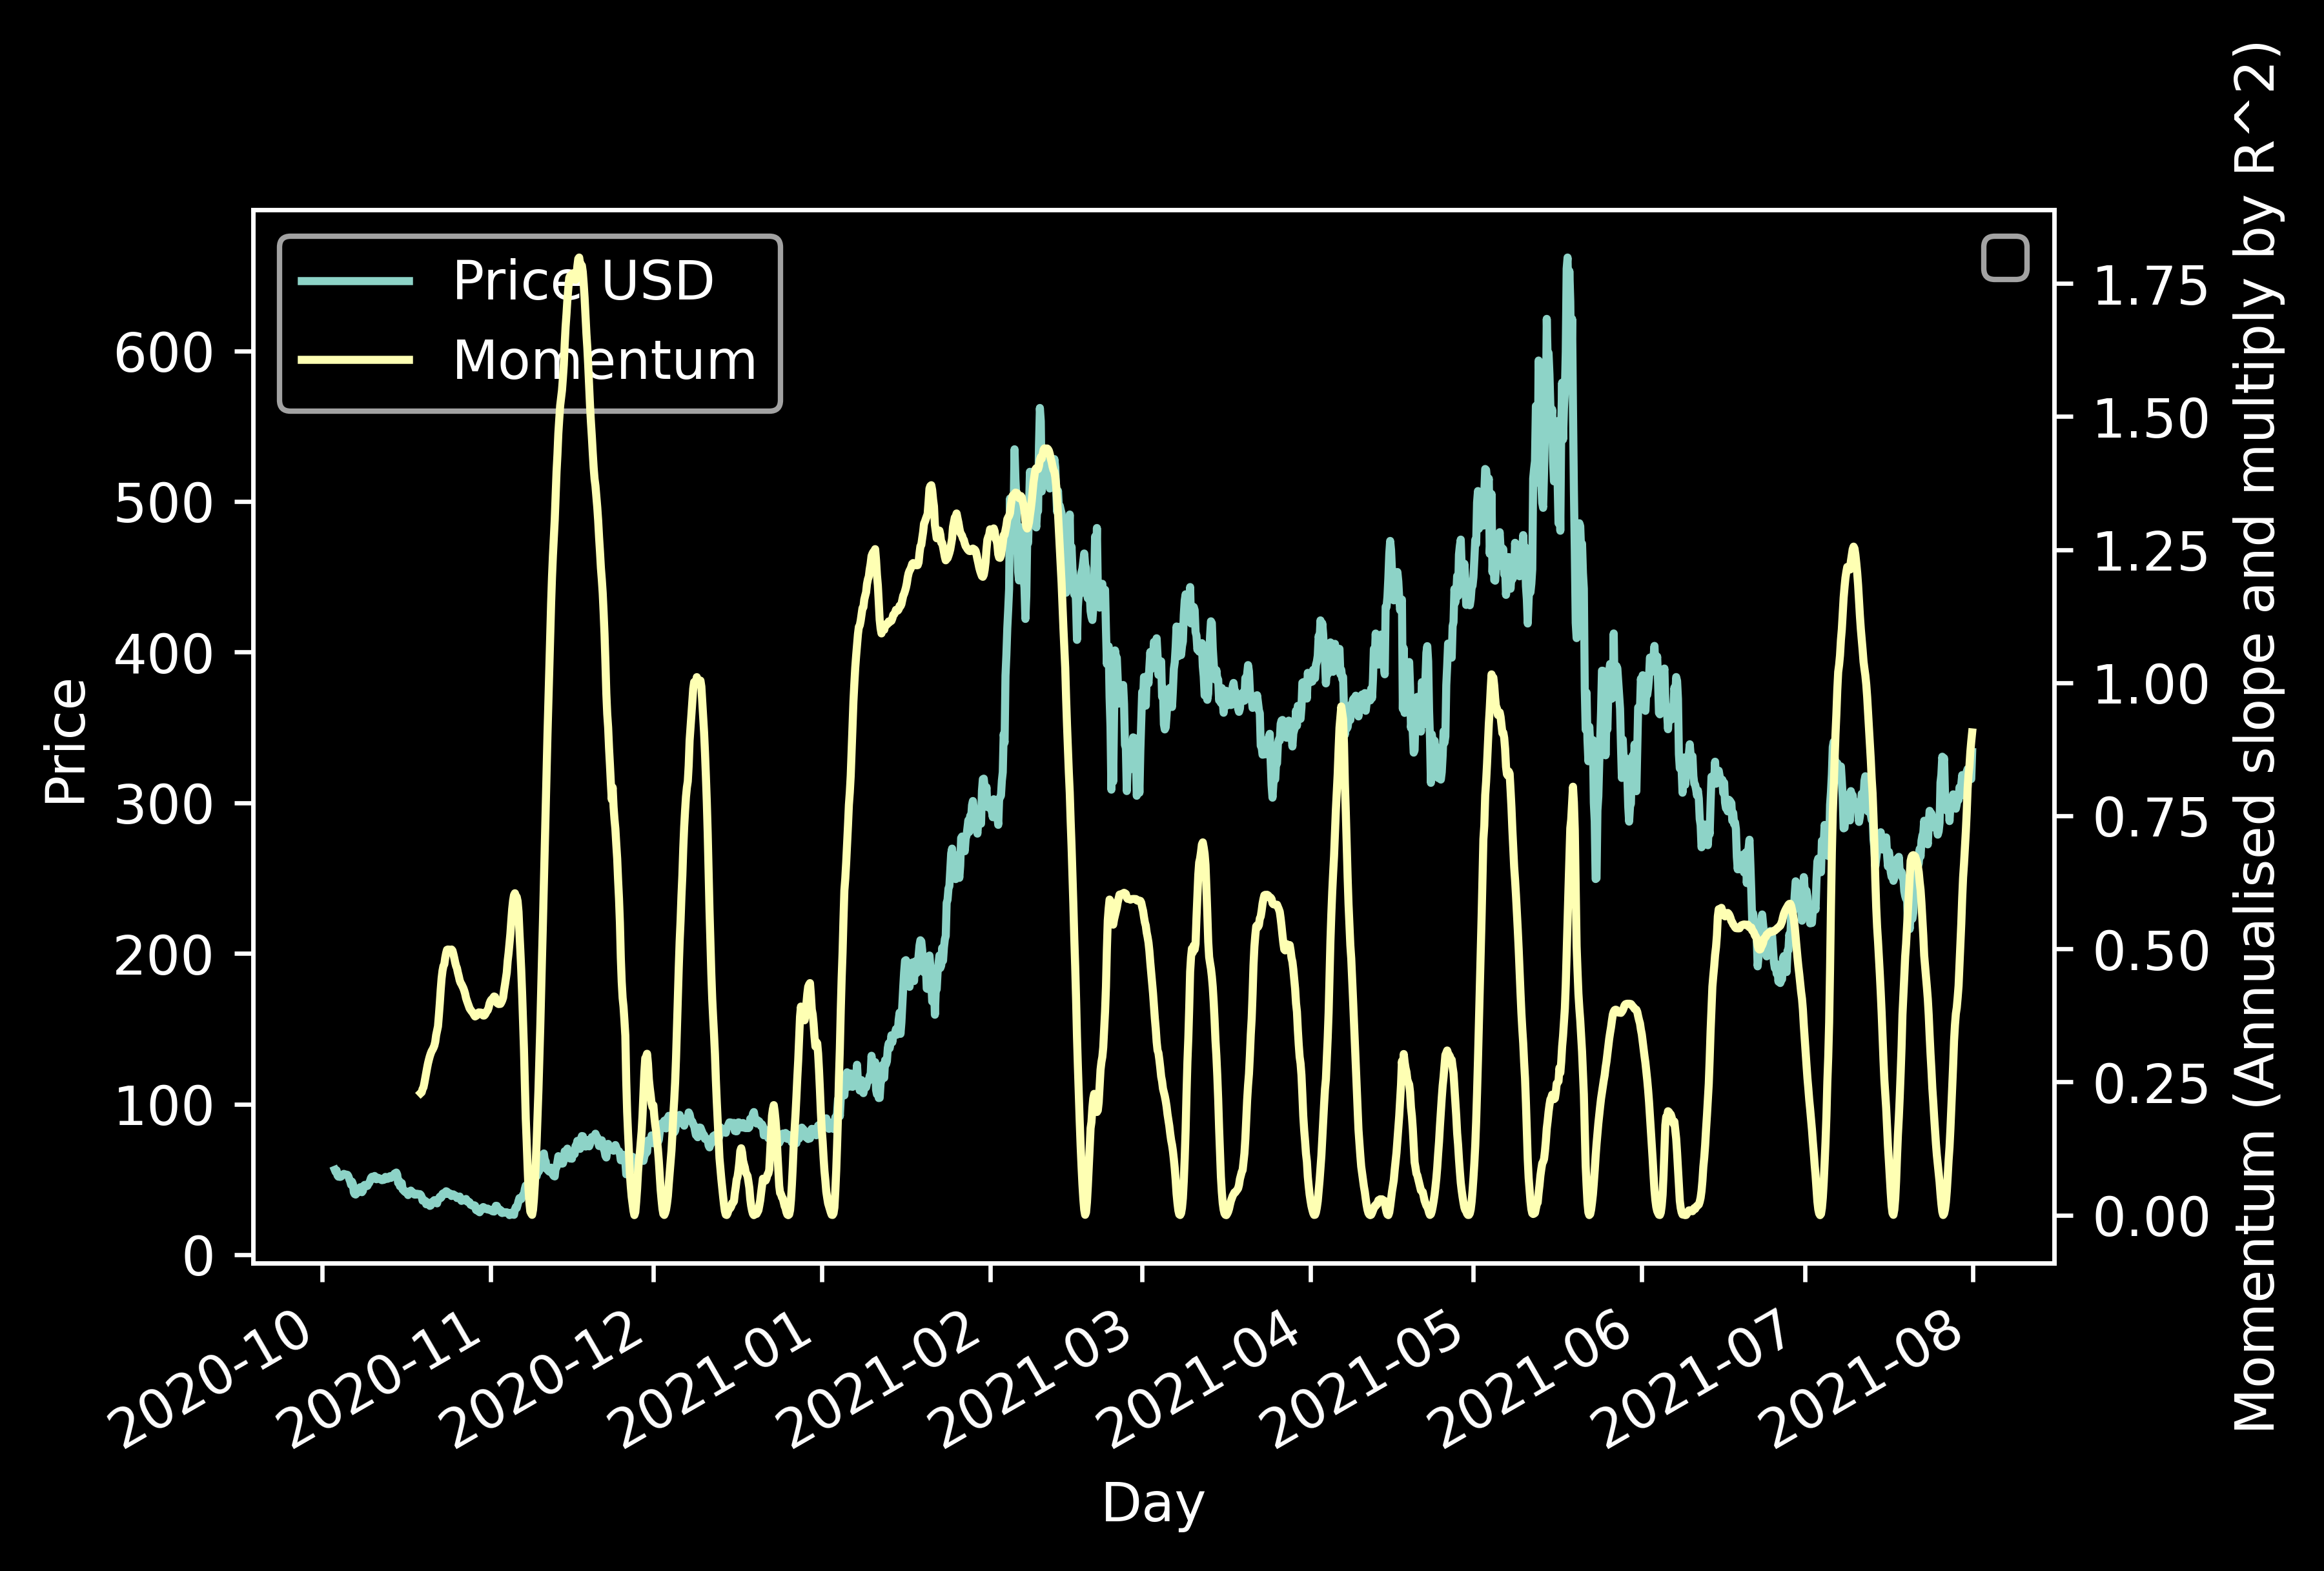

In [26]:
# https://stackoverflow.com/questions/14762181/adding-a-y-axis-label-to-secondary-y-axis-in-matplotlib
fig, ax1 = pyplot.subplots()

ax1.set_xlabel('Day')
ax1.set_ylabel('Price')
ax1.legend()

ax2 = ax1.twinx()
ax2.set_ylabel("Momentum (Annualised slope and multiply by R^2)")
ax2.legend(loc=0)  #
ax2._get_lines.prop_cycler = ax1._get_lines.prop_cycler

price = aave_eth_candles["close"]
momentum = aave_eth_candles["momentum"]

end = momentum.index.get_loc(momentum.idxmax())
rets = np.log(price.iloc[end - 90 : end])
x = np.arange(len(rets))
slope, intercept, r_value, p_value, std_err = linregress(x, rets)

lns1 = ax1.plot(price.index, price, label="Price USD")
lns2= ax2.plot(price.index, momentum, label="Momentum")

# Put twin Y-axis labels together
lns = lns1 + lns2
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc=0)

pyplot.gcf().autofmt_xdate()
pyplot.show()